In [3]:
import os
import numpy as np
import pandas as pd
import time, datetime

import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.cluster import KMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import MeanShift





In [4]:
curr_wd = os.getcwd()
data_dir = os.path.join(curr_wd, 'Data')
data_dir

'/Users/derekwang/Work/Forecasting/Final_Forecast_Process_0108/Data'

In [5]:
demand_raw_dir = os.path.join(data_dir, '3yearsSalesNew.txt')
demand_raw_df = pd.read_csv(demand_raw_dir, sep = '\t', header=0)
print (np.size(demand_raw_df, 0))
demand_raw_df.head()

12649939


,Subclass,SKU,Store,WEEK,Units
0,12,247,271,201450,2.0
1,12,237,351,201528,1.0
2,12,246,473,201625,1.0
3,12,263,261,201510,0.0
4,12,249,484,201620,0.0


In [7]:
add_raw_demand_dir1 = os.path.join(data_dir, 'Week1_4New.txt')
add_raw_demand_df1 = pd.read_csv(add_raw_demand_dir1, sep='\t', header=0)
print('CNT of rows from week1 to 4: %d' % np.size(add_raw_demand_df1, 0))

add_raw_demand_dir2 = os.path.join(data_dir, 'Week5_8New.txt')
add_raw_demand_df2 = pd.read_csv(add_raw_demand_dir2, sep='\t', header=0)
add_raw_demand_df2=add_raw_demand_df2.rename(columns={'Week':'WEEK'})
print('CNT of rows from week5 to 8: %d' % np.size(add_raw_demand_df2, 0))


add_pieces=[]
add_pieces.append(add_raw_demand_df1)
add_pieces.append(add_raw_demand_df2)
add_raw_demand_df=pd.concat(add_pieces)
print('CNT of SKU_Store for add_demand: %d' % np.size(add_raw_demand_df, 0))
add_raw_demand_df.head()

CNT of rows from week1 to 4: 357548
CNT of rows from week5 to 8: 357548
CNT of SKU_Store for add_demand: 715096


,Subclass,SKU,Store,WEEK,Units
0,1,6,101,201701,11.0
1,1,6,101,201702,20.0
2,1,6,101,201703,14.0
3,1,6,101,201704,10.0
4,1,6,102,201701,20.0


In [8]:
format_add = add_raw_demand_df.sort_values(['Subclass', 'SKU', 'Store', 'WEEK'])
LIST = format_add.loc[:, ['SKU', 'Store']].drop_duplicates().copy().reset_index(drop=True)

add_sales = format_add[(format_add.WEEK >= 201701)]['Units'].values.reshape(-1,add_raw_demand_df.WEEK.nunique())
add_sales_df = pd.DataFrame(add_sales, columns = [i for i in range(1, add_raw_demand_df.WEEK.nunique()+1)])

add_df = pd.concat([LIST, add_sales_df], axis = 1)
add_df.head()

,SKU,Store,1,2,3,4,5,6,7,8
0,6,101,11.0,20.0,14.0,10.0,21.0,17.0,8.0,14.0
1,6,102,20.0,2.0,9.0,4.0,4.0,10.0,26.0,14.0
2,6,103,10.0,5.0,17.0,15.0,6.0,7.0,3.0,22.0
3,6,104,15.0,12.0,12.0,3.0,14.0,19.0,5.0,19.0
4,6,105,31.0,71.0,16.0,19.0,5.0,20.0,10.0,19.0


In [42]:
format_df = demand_raw_df.sort_values(['Subclass', 'SKU', 'Store'])
format_df.to_csv(os.path.join(data_dir, 'Sorted_raw_demand.csv'))
STR_SKU_LIST = format_df.loc[:, ['Subclass','SKU', 'Store']].drop_duplicates().copy().reset_index(drop=True)

week_list_2014 = [i for i in range(201401, 201453)]
week_list_2015 = [i for i in range(201501, 201553)]
week_list_2016 = [i for i in range(201601, 201653)]

week_list_2014_df = pd.DataFrame(week_list_2014, columns=['WEEK'])
week_list_2015_df = pd.DataFrame(week_list_2015, columns=['WEEK'])
week_list_2016_df = pd.DataFrame(week_list_2016, columns=['WEEK'])

week_2014 = week_list_2014_df.copy().append([week_list_2014_df] * (np.size(STR_SKU_LIST, 0)-1))
week_2015 = week_list_2015_df.copy().append([week_list_2015_df] * (np.size(STR_SKU_LIST, 0)-1))
week_2016 = week_list_2016_df.copy().append([week_list_2016_df] * (np.size(STR_SKU_LIST, 0)-1))

l = STR_SKU_LIST.copy().append([STR_SKU_LIST] * (np.size(week_list_2014_df, 0)-1)).sort_values(['Subclass','SKU', 'Store']).reset_index(drop=True)

header_values_2014 = np.concatenate((l.values, week_2014.values), axis = 1)
header_values_2015 = np.concatenate((l.values, week_2015.values), axis = 1)
header_values_2016 = np.concatenate((l.values, week_2016.values), axis = 1)

headers_df_2014 = pd.DataFrame(header_values_2014, columns = ['Subclass', 'SKU', 'Store', 'WEEK'])
headers_df_2015 = pd.DataFrame(header_values_2015, columns = ['Subclass', 'SKU', 'Store', 'WEEK'])
headers_df_2016 = pd.DataFrame(header_values_2016, columns = ['Subclass', 'SKU', 'Store', 'WEEK'])


In [44]:
demand_raw_2014 = demand_raw_df[(demand_raw_df.WEEK >=201401) & (demand_raw_df.WEEK <201501)]
demand_raw_2015 = demand_raw_df[(demand_raw_df.WEEK >=201501) & (demand_raw_df.WEEK <201601)]
demand_raw_2016 = demand_raw_df[(demand_raw_df.WEEK >=201601) & (demand_raw_df.WEEK <201701)]


demand_with_Nan_2014 = pd.merge(headers_df_2014, demand_raw_2014, how='left', on=['Subclass', 'SKU', 'Store', 'WEEK'])
demand_with_Nan_2015 = pd.merge(headers_df_2015, demand_raw_2015, how='left', on=['Subclass', 'SKU', 'Store', 'WEEK'])
demand_with_Nan_2016 = pd.merge(headers_df_2016, demand_raw_2016, how='left', on=['Subclass', 'SKU', 'Store', 'WEEK'])
# demand_with_Nan.head()

In [50]:
D_values_2014 = demand_with_Nan_2014['Units'].values.reshape(-1, 1)
D_values_2015 = demand_with_Nan_2015['Units'].values.reshape(-1, 1)
D_values_2016 = demand_with_Nan_2016['Units'].values.reshape(-1, 1)

two_years_mean = np.nanmean((D_values_2014, D_values_2015), axis = 0).reshape(-1, 52)
three_years_mean = np.nanmean((D_values_2014, D_values_2015, D_values_2016), axis = 0).reshape(-1, 52)

df_2Years = pd.DataFrame(two_years_mean, columns = [i for i in range(1,53)])
df_3Years = pd.DataFrame(three_years_mean, columns = [i for i in range(1,53)])

df_Year1 = pd.DataFrame(D_values_2014.reshape(-1, 52), columns = [i for i in range(1,53)])
df_Year2 = pd.DataFrame(D_values_2015.reshape(-1, 52), columns = [i for i in range(1,53)])
df_Year3 = pd.DataFrame(D_values_2016.reshape(-1, 52), columns = [i for i in range(1,53)])

two_years_mean_df = pd.concat([STR_SKU_LIST, df_2Years], axis = 1).drop(['Subclass'], axis = 1)
three_years_mean_df = pd.concat([STR_SKU_LIST, df_3Years], axis = 1).drop(['Subclass'], axis = 1)

year1_df = pd.concat([STR_SKU_LIST, df_Year1], axis = 1).drop(['Subclass'], axis = 1)
year2_df = pd.concat([STR_SKU_LIST, df_Year2], axis = 1).drop(['Subclass'], axis = 1)
year3_df = pd.concat([STR_SKU_LIST, df_Year3], axis = 1).drop(['Subclass'], axis = 1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [53]:
#Functions:

def calc_ncq(df):
    ncq_df = df.iloc[:,2:54].cumsum(axis = 1)
    ncq_max = ncq_df.iloc[:,-1]
    ncq_out =  ncq_df.values /  ncq_max.values[:,None]
    out_df = df.copy()
    out_df.iloc[:,2:54] = ncq_out
    
    return out_df

def scal_qty(df):
    scal_df = df.iloc[:,2:54].copy()
    scal_mean = scal_df.mean(axis = 1)
    scal_out =  scal_df.values /  scal_mean.values[:,None]
    out_df = df.copy()
    out_df.iloc[:,2:54] = scal_out
    
    return out_df

def get_km_result_df(data_ncq, data_scal, kmeans):
    title_df = data_ncq.loc[:,['SKU', 'Store']]
    title_df['Class_label'] = kmeans.labels_
    scal_df = title_df.merge(data_scal, how = 'left', on =['SKU', 'Store'])
    centers_df = scal_df.iloc[:,2:].groupby('Class_label').mean().copy()
    centers_df.reset_index(inplace=True)
    kmean_result_df = title_df.merge(centers_df, how = 'left', on =['Class_label'])
    
    return kmean_result_df

def scal_error_est(km_result, year3_df):
    year3_scal = scal_qty(year3_df)
    compare = km_result.merge(year3_scal, how = 'left', on =['SKU', 'Store'])
    error_matrix = compare.iloc[:,3:55].values - compare.iloc[:,55:107].values
    
    squared_error = np.sum(np.square(error_matrix))
    return squared_error

def ncq_error_est(km_result, year3_df):
    year3_clean = year3_df.dropna(axis = 0, how = 'any')
    year3_clean = year3_clean[(year3_clean.iloc[:,2:54].sum(axis =1) > 0)]
    year3_ncq = calc_ncq(year3_clean)
    km = calc_ncq(km_result.drop(['Class_label'], axis = 1))
    compare = km.merge(year3_ncq, how = 'inner', on =['SKU', 'Store'])
    error_matrix = compare.iloc[:,2:54].values - compare.iloc[:,54:106].values
    
    squared_error = np.sum(np.square(error_matrix))
    return squared_error

def get_Kmeans_fcst(base_df, factors_df):
    merge = pd.merge(base_df, factors_df.drop(['Class_label'], axis=1), how='inner', on=['SKU', 'Store'])
    matrix_base = merge.iloc[:,2:54].values
    matrix_factors = merge.iloc[:,54:106].values
    matrix_fcst = matrix_base*matrix_factors
    fcst_df = pd.DataFrame(matrix_fcst, columns=['Wk%d' % i for i in range(1,53)])
    result = pd.concat([merge.loc[:,['SKU','Store']], fcst_df], axis =1)
    return result

Count of Store_SKU in ewma: 75108
Count of Store_SKU in slow_mover: 23100
Count of Store_SKU to be processed: 52008
2018-01-17 11:47:48.558287
2018-01-17 11:48:04.024609
Error for 20 is: 18478.1406092
2018-01-17 11:48:04.024716
2018-01-17 11:48:23.083999
Error for 21 is: 18492.1303559
2018-01-17 11:48:23.084592
2018-01-17 11:48:45.448854
Error for 22 is: 18431.0386787
2018-01-17 11:48:45.448964
2018-01-17 11:49:08.721767
Error for 23 is: 18415.4107112
2018-01-17 11:49:08.721902
2018-01-17 11:49:29.757465
Error for 24 is: 18384.6732626
2018-01-17 11:49:29.757574
2018-01-17 11:49:55.162876
Error for 25 is: 18363.2710526
2018-01-17 11:49:55.163015
2018-01-17 11:50:15.217440
Error for 26 is: 18299.3470272
2018-01-17 11:50:15.217550
2018-01-17 11:50:42.499460
Error for 27 is: 18278.4372025
2018-01-17 11:50:42.499570
2018-01-17 11:51:08.352587
Error for 28 is: 18291.5624534
2018-01-17 11:51:08.352696
2018-01-17 11:51:40.112146
Error for 29 is: 18291.7028766
2018-01-17 11:51:40.112261
2018-01

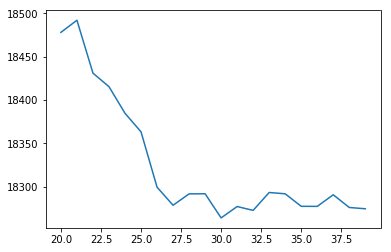

In [14]:
#Try to find the best K

#drop rows with any 'null' value 
#drop rows with sum of all sales equal to zero
data_clean = two_years_mean_df.dropna(axis = 0, how = 'any')
data_clean = data_clean[(data_clean.iloc[:,2:54].sum(axis =1) > 0)]

#smooth raw demand using exponential weighted moving average
data_ewma = data_clean.copy()
data_ewma.iloc[:,2:54] = data_clean.iloc[:,2:54].ewm(span = 4, axis = 1).mean()
print('Count of Store_SKU in ewma: %d' % np.size(data_ewma, 0))

#set threshhold for sales volume, item will be grouped together when annully sales <= 52
data_slow_mover = data_ewma[(data_ewma.iloc[:,2:54].sum(axis =1) <= 52)]
data_slow_mover = data_slow_mover.iloc[:, 0:54]
print ('Count of Store_SKU in slow_mover: %d' % np.size(data_slow_mover, 0))

#set threshhold for sales volume, item can be processed when annully sales > 52
data_vol = data_ewma[(data_ewma.iloc[:,2:54].sum(axis =1) > 52)]
print ('Count of Store_SKU to be processed: %d' % np.size(data_vol, 0))


data_ncq = calc_ncq(data_vol)
data_scal = scal_qty(data_vol)


#Finding best K for target dataset
test_list =[i for i in range(20, 40) ]
squared_error = []
for i in test_list:
    print (str(datetime.datetime.now()))
    X_train = data_ncq.iloc[:,2:54].values
    kmeans = KMeans(n_clusters = i, random_state=0).fit(X_train)
    error = ncq_error_est(get_km_result_df(data_ncq, data_scal, kmeans), year3_df)
    squared_error.append(error)
    print (str(datetime.datetime.now()))
    print ("Error for %d is: %s" % (i, error))

print(squared_error)


plt.plot(test_list, squared_error)
plt.show()


In [54]:
final_k = test_list[squared_error.index(min(squared_error))]
final_k

30

In [55]:
#final run with best k


#drop rows with any 'null' value 
#drop rows with sum of all sales equal to zero
data_clean = three_years_mean_df.dropna(axis = 0, how = 'any')
data_clean = data_clean[(data_clean.iloc[:,2:54].sum(axis =1) > 0)]

#smooth raw demand using exponential weighted moving average
data_ewma = data_clean.copy()
data_ewma.iloc[:,2:54] = data_clean.iloc[:,2:54].ewm(span = 4, axis = 1).mean()
print('Count of Store_SKU in ewma: %d' % np.size(data_ewma, 0))

#set threshhold for sales volume, item will be grouped together when annully sales <= 52
data_slow_mover = data_ewma[(data_ewma.iloc[:,2:54].sum(axis =1) <= 52)]
data_slow_mover = data_slow_mover.iloc[:, 0:54]
print ('Count of Store_SKU in slow_mover: %d' % np.size(data_slow_mover, 0))

#set threshhold for sales volume, item can be processed when annully sales > 52
data_vol = data_ewma[(data_ewma.iloc[:,2:54].sum(axis =1) > 52)]
print ('Count of Store_SKU to be processed: %d' % np.size(data_vol, 0))


data_ncq = calc_ncq(data_vol)
data_scal = scal_qty(data_vol)


print (str(datetime.datetime.now()))
X_train = data_ncq.iloc[:,2:54].values
kmeans = KMeans(n_clusters = final_k, random_state=0).fit(X_train)

pieces = []

#get the result from Kmeans
kmeans_result = get_km_result_df(data_ncq, data_scal, kmeans)
pieces.append(kmeans_result)


#get labels for slow movers
scal_slow_mover = scal_qty(data_slow_mover)
scal_slow_mover['Class_label'] = np.array([9999]*np.size(scal_slow_mover, 0))
slow_mover_centers = scal_slow_mover.iloc[:,2:].groupby('Class_label').mean()
slow_mover_centers.reset_index(inplace=True)
slow_mover_result = scal_slow_mover.loc[:,['SKU', 'Store', 'Class_label']].merge(slow_mover_centers, how='left', on=['Class_label'])

pieces.append(slow_mover_result)

df_result = pd.concat(pieces)
df_result['SKU'] = df_result['SKU'].astype('object')
df_result['Store'] = df_result['Store'].astype('object')

print (str(datetime.datetime.now()))

df_result.head()



Count of Store_SKU in ewma: 87161
Count of Store_SKU in slow_mover: 32596
Count of Store_SKU to be processed: 54565
2018-01-17 12:40:27.629388
2018-01-17 12:40:54.505459


,SKU,Store,Class_label,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,6,101,10,0.799264,0.817028,0.856657,0.885559,0.947358,1.005871,1.070763,...,0.749903,0.744947,0.727121,0.691882,0.634831,0.624605,0.620783,0.636247,0.656791,0.690319
1,6,102,0,0.873729,0.869588,0.898164,0.923993,0.945611,0.960064,0.970239,...,0.935151,0.951354,0.947344,0.928604,0.844982,0.854704,0.873811,0.890390,0.906829,0.925147
2,6,103,9,0.424626,0.442938,0.490592,0.536237,0.584384,0.650649,0.692235,...,0.827522,0.807352,0.776935,0.732731,0.649548,0.627865,0.609925,0.612708,0.613187,0.616289
3,6,104,25,0.666554,0.681822,0.734124,0.767015,0.824275,0.876862,0.928394,...,0.791977,0.777796,0.762698,0.722975,0.644892,0.629989,0.623279,0.636312,0.660713,0.694529
4,6,105,25,0.666554,0.681822,0.734124,0.767015,0.824275,0.876862,0.928394,...,0.791977,0.777796,0.762698,0.722975,0.644892,0.629989,0.623279,0.636312,0.660713,0.694529


In [57]:
#export seasonal factors at str_sku level
df_export = df_result.copy()
# df_export.to_csv(os.path.join(data_dir, 'Output\\Seasonalities_0116.csv'))
df_export.head()

,SKU,Store,Class_label,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,6,101,10,0.799264,0.817028,0.856657,0.885559,0.947358,1.005871,1.070763,...,0.749903,0.744947,0.727121,0.691882,0.634831,0.624605,0.620783,0.636247,0.656791,0.690319
1,6,102,0,0.873729,0.869588,0.898164,0.923993,0.945611,0.960064,0.970239,...,0.935151,0.951354,0.947344,0.928604,0.844982,0.854704,0.873811,0.890390,0.906829,0.925147
2,6,103,9,0.424626,0.442938,0.490592,0.536237,0.584384,0.650649,0.692235,...,0.827522,0.807352,0.776935,0.732731,0.649548,0.627865,0.609925,0.612708,0.613187,0.616289
3,6,104,25,0.666554,0.681822,0.734124,0.767015,0.824275,0.876862,0.928394,...,0.791977,0.777796,0.762698,0.722975,0.644892,0.629989,0.623279,0.636312,0.660713,0.694529
4,6,105,25,0.666554,0.681822,0.734124,0.767015,0.824275,0.876862,0.928394,...,0.791977,0.777796,0.762698,0.722975,0.644892,0.629989,0.623279,0.636312,0.660713,0.694529


In [59]:
#Get ARIMA output

ARIMA_dir = os.path.join(data_dir, 'arima_output116.csv')
ARIMA_df_raw = pd.read_csv(ARIMA_dir, sep = ',', header = 0, index_col=0).sort_values(by=['SKU', 'STORE', 'WEEKNO'])
ARIMA_df_raw.reset_index(drop=True)
STR_SKU_LIST = ARIMA_df_raw.loc[:, ['SKU', 'STORE']].drop_duplicates().copy().reset_index(drop=True)

ARIMA_output = ARIMA_df_raw['ARIMA_OUTPUT'].values.reshape(-1,48)
ARIMA_h = pd.DataFrame(ARIMA_output, columns = [i for i in range(5,53)])
ARIMA_df = pd.concat([STR_SKU_LIST, ARIMA_h], axis=1)
ARIMA_df = ARIMA_df.rename(columns = {'STORE': 'Store'})
ARIMA_df.head()


/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,SKU,Store,5,6,7,8,9,10,11,12,...,43,44,45,46,47,48,49,50,51,52
0,1,101,4.577412,4.336050,4.307306,4.303882,4.303475,4.303426,4.303420,4.303420,...,4.303420,4.303420,4.303420,4.303420,4.303420,4.303420,4.303420,4.303420,4.303420,4.303420
1,1,102,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,...,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110,5.201110
2,1,103,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,...,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252,8.202252
3,1,104,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,...,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461,14.657461
4,1,105,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,...,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689,6.968689


In [60]:
#Need to change index according to targeted forecast time period 

def get_Kmeans_fcst(base_df, factors_df):
    merge = pd.merge(base_df, factors_df.drop(['Class_label'], axis=1), how='inner', on=['SKU', 'Store'])
    matrix_base = merge.iloc[:,2:50].values
    matrix_factors = merge.iloc[:,54:102].values
    matrix_fcst = matrix_base*matrix_factors
    fcst_df = pd.DataFrame(matrix_fcst, columns=['Wk%d' % i for i in range(5,53)])
    result = pd.concat([merge.loc[:,['SKU','Store']], fcst_df], axis =1)
    return result



kmean_fcst = get_Kmeans_fcst(ARIMA_df, df_result)
# kmean_fcst.to_csv(os.path.join(data_dir, 'Output/final_forecast_0109.csv'))
kmean_fcst.head()

,SKU,Store,Wk5,Wk6,Wk7,Wk8,Wk9,Wk10,Wk11,Wk12,...,Wk43,Wk44,Wk45,Wk46,Wk47,Wk48,Wk49,Wk50,Wk51,Wk52
0,1,101,6.274026,5.802404,5.576203,5.400606,5.254636,5.092479,4.976665,4.889115,...,3.687902,3.800121,3.823983,3.747087,3.656022,3.741082,3.818076,3.870352,3.940975,4.160065
1,1,102,4.969717,5.024330,5.011400,5.035021,5.042988,5.001289,4.968784,4.959163,...,5.601374,5.730280,5.738170,5.689931,5.265064,5.377726,5.432963,5.449223,5.465542,5.462722
2,1,103,7.837341,7.923466,7.903075,7.940325,7.952891,7.887131,7.835869,7.820696,...,8.833475,9.036762,9.049206,8.973131,8.303108,8.480778,8.567889,8.593531,8.619266,8.614819
3,1,104,15.880498,15.913999,15.990159,15.979242,16.093909,16.053561,15.913590,16.020356,...,12.944358,13.137686,13.068770,12.814043,11.846409,11.975531,12.147631,12.453073,12.758123,13.112423
4,1,105,8.143437,8.692209,9.268064,9.552034,9.854394,9.923831,10.069530,10.310455,...,4.454962,4.441362,4.353385,4.185768,3.835638,3.840496,3.861543,4.089124,4.396743,4.834415


In [114]:
#save kmean fcst 
kmean_fcst.to_csv(os.path.join(data_dir, 'Output/FCST_Wk5_52.csv'))

In [78]:
#combine fcst with 2017 given sales for whole year data

kmean_fcst_head = kmean_fcst.iloc[:,0:2]
given_sales = pd.merge(kmean_fcst_head, add_df, how = 'left', on=['SKU', 'Store'])
combined_fcst = pd.merge(given_sales, kmean_fcst, how = 'left', on = ['SKU', 'Store'])
combined_fcst.head()

,SKU,Store,1,2,3,4,Wk5,Wk6,Wk7,Wk8,...,Wk43,Wk44,Wk45,Wk46,Wk47,Wk48,Wk49,Wk50,Wk51,Wk52
0,1,101,4.0,1.0,2.0,9.0,6.274026,5.802404,5.576203,5.400606,...,3.687902,3.800121,3.823983,3.747087,3.656022,3.741082,3.818076,3.870352,3.940975,4.160065
1,1,102,7.0,2.0,1.0,0.0,4.969717,5.024330,5.011400,5.035021,...,5.601374,5.730280,5.738170,5.689931,5.265064,5.377726,5.432963,5.449223,5.465542,5.462722
2,1,103,2.0,8.0,3.0,2.0,7.837341,7.923466,7.903075,7.940325,...,8.833475,9.036762,9.049206,8.973131,8.303108,8.480778,8.567889,8.593531,8.619266,8.614819
3,1,104,23.0,10.0,22.0,11.0,15.880498,15.913999,15.990159,15.979242,...,12.944358,13.137686,13.068770,12.814043,11.846409,11.975531,12.147631,12.453073,12.758123,13.112423
4,1,105,7.0,5.0,3.0,0.0,8.143437,8.692209,9.268064,9.552034,...,4.454962,4.441362,4.353385,4.185768,3.835638,3.840496,3.861543,4.089124,4.396743,4.834415


In [66]:
def plot_sls(df, *num_plot):
    if not num_plot:
        for i in range(np.size(df, 0)):
            plt.plot(df.iloc[i, 2:].values)
    else:
        rand_int = np.random.randint(0, np.size(df, 0), num_plot[0])
        plot_df = df.iloc[rand_int, :]
        plot_data = plot_df.iloc[:, 2:]
        item_loc = plot_df.iloc[:,0:2]

        for i in range(num_plot[0]):
            plt.plot(plot_data.iloc[i].values)
    
    ticks = np.arange(0, 52, 5)
    labels = np.arange(1, 53, 5)
    plt.xticks(ticks, labels)
    print (item_loc)
    plt.show()
    
    
def plot_sales_fcst(SKU, Store):
    sales_2014 = year1_df[(year1_df.SKU == SKU) & (year1_df.Store == Store)].iloc[:,2:]
    sales_2015 = year2_df[(year2_df.SKU == SKU) & (year2_df.Store == Store)].iloc[:,2:]
    sales_2016 = year3_df[(year3_df.SKU == SKU) & (year3_df.Store == Store)].iloc[:,2:]
    fcst = combined_fcst[(kmean_fcst.SKU == SKU) & (kmean_fcst.Store == Store)].iloc[:,2:]
    
    plt.figure(figsize=(12, 9))
    sales2014, = plt.plot(sales_2014.iloc[0].values, label = 'sales2014')
    sales2015, = plt.plot(sales_2015.iloc[0].values, label = 'sales2015')
    sales2016, = plt.plot(sales_2016.iloc[0].values, label = 'sales2016')
    fcst, = plt.plot(fcst.iloc[0].values, label = 'fcst')
    ticks = np.arange(0, 52, 5)
    labels = np.arange(1, 53, 5)
    plt.xticks(ticks, labels)
    plt.legend(handles=[sales2014, sales2015, sales2016, fcst])
    
    plt.show()

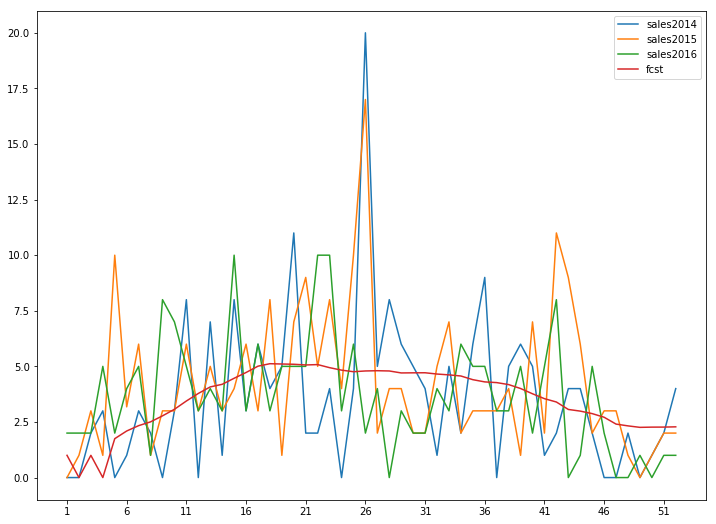

In [141]:
#plot sales hist and fcst for a SKU, Store
plot_sales_fcst(106, 349)

#Good pairs:
#(37, 190), (106, 349), (52, 321), (102, 481)
#Bad paris:
#(191, 206), (175, 355), (175, 194)


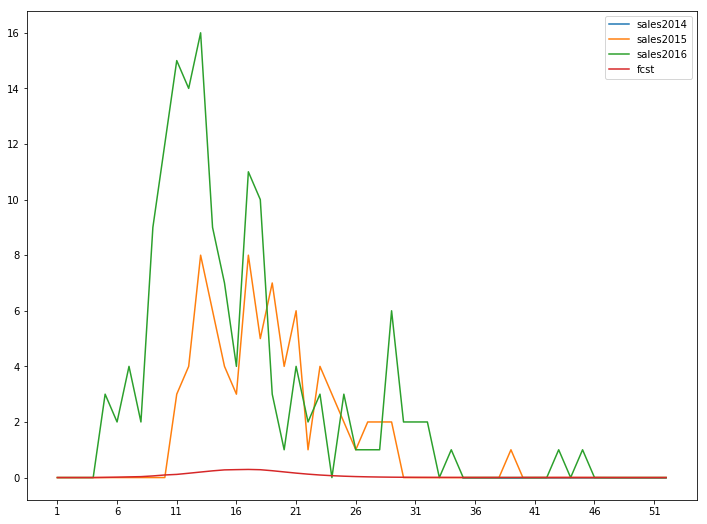

In [142]:
#plot sales hist and fcst for a SKU, Store
plot_sales_fcst(175, 355)

       SKU Store
13064   36   501
57867  188   296


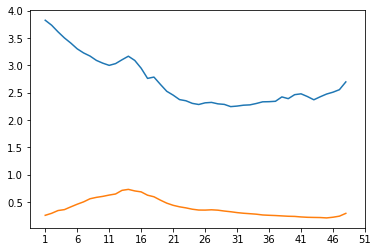

In [120]:
plot_sls(kmean_fcst,2)